In [2]:
import polars as pl 
from dotenv import load_dotenv
import os 
import glob 
import numpy as np 
import sys, os
from sippy import *
import numpy as np
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import matplotlib.pyplot as plt
import pandas as pd
import control as cnt
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','ieee'])

np.random.seed(12345)

#define folder path and file path
folder_path = "/home/alqua/data/boiler_data/daily_data"

#load all the .cvs files in the folder 
csv_files_list = glob.glob(os.path.join(folder_path, "*.csv"))

dfs = []
#split the 
for csv_file in csv_files_list:
    # read the data
    # print(csv_file)
    data = pl.read_csv(csv_file)
    #load the data
    data = data.with_columns(
        pl.col("UTC").str.to_datetime("%Y-%m-%d %H:%M:%S+00:00").alias("UTC")
    )
    data = data.with_columns(pl.all().exclude("UTC").cast(pl.Float64))
    data = data.slice(0,27)
    dfs.append(data)

data = pl.concat(dfs)
data = data.sort("UTC")

last_measurement = str(data.select("UTC").tail(n=1).cast(pl.Date).item().strftime("%Y_%m_%d"))

In [3]:
sysid_data = data.select(['UTC','L11 Heat storage energy [MWh]', 'Heat load forecast [MW]']).drop_nulls()

In [4]:
import polars as pl

# Assuming sysid_data is a Polars DataFrame
sysid_data = sysid_data.with_columns(
    pl.col("Heat load forecast [MW]").shift(-1).alias("Heat load forecast [MW]_shifted")
)


In [5]:
sysid_data.write_parquet("../data/boiler_data.parquet")

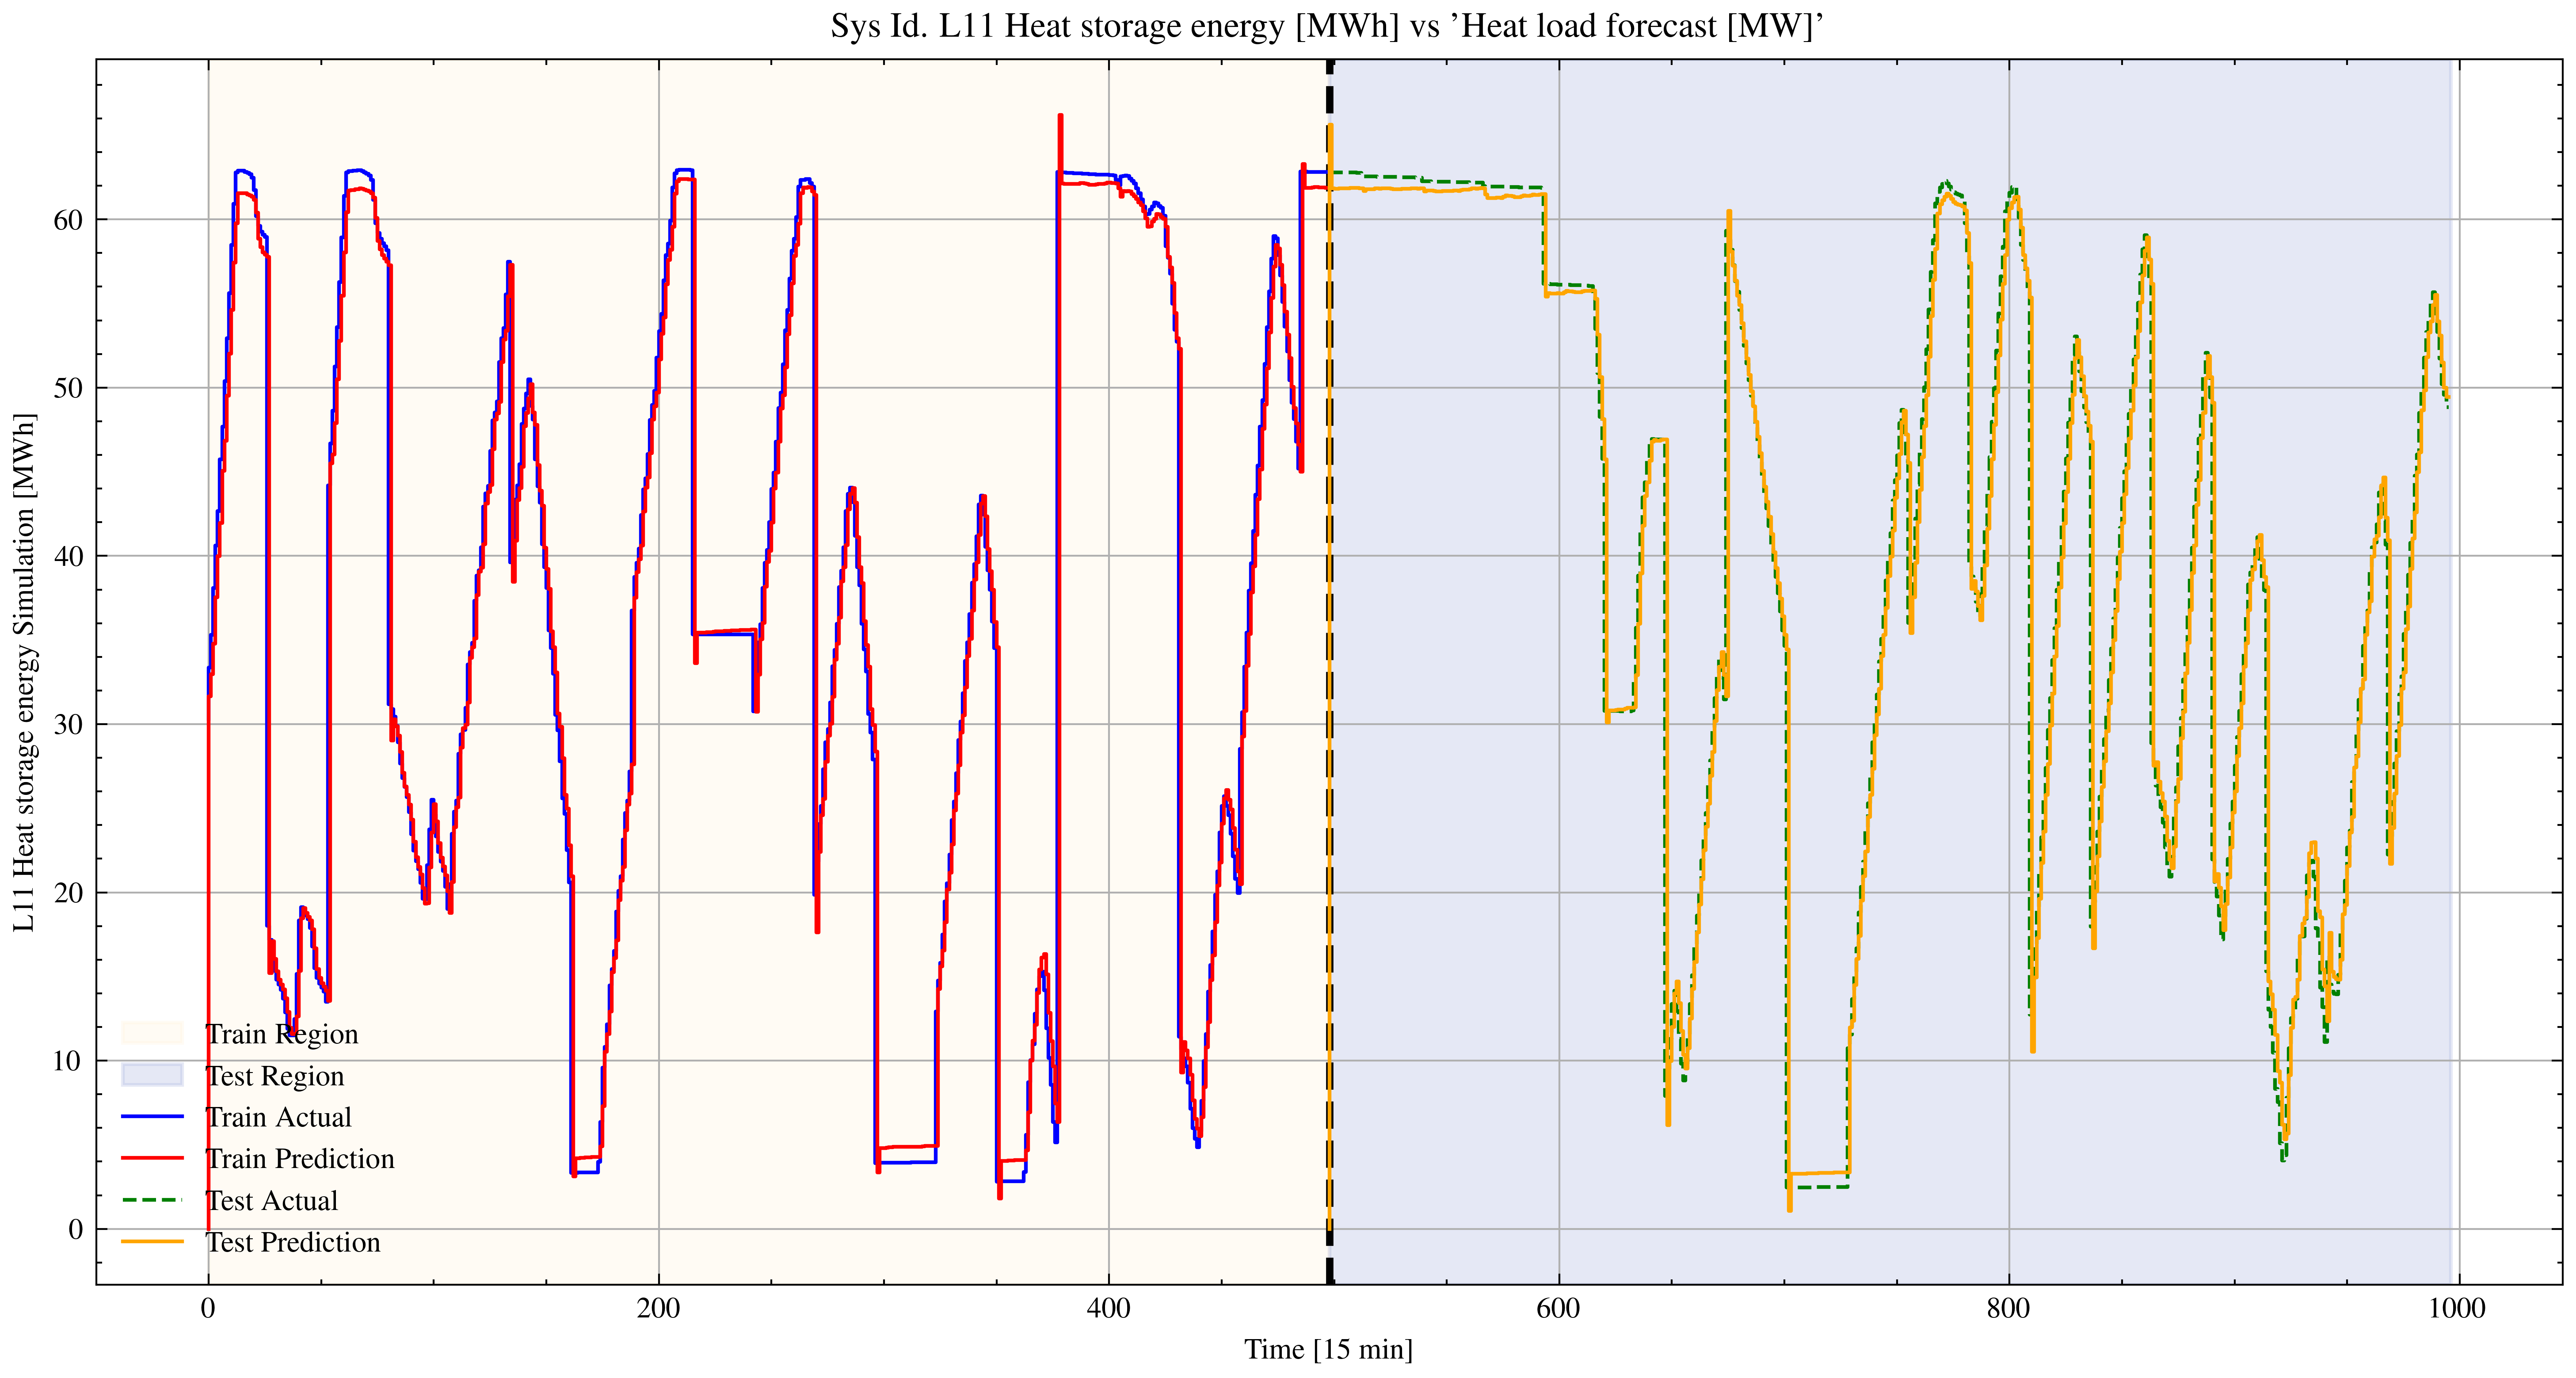

In [6]:
y = sysid_data.select(['L11 Heat storage energy [MWh]']).to_numpy()
u = sysid_data.select(['Heat load forecast [MW]']).to_numpy()
train_size = int(0.5 * len(y))
u_train, u_test = u[:train_size], u[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
na_ords = [2]         
nb_ords = [[2]]       
theta = [[0]] 

id_ARX = system_identification(y_train, u_train, 'ARX',
                             ARX_orders=[na_ords, nb_ords, theta])  

G = id_ARX.G 

num = id_ARX.NUMERATOR
den = id_ARX.DENOMINATOR

import numpy as np
import matplotlib.pyplot as plt

k = 1
time_train = np.arange(len(u_train))
time_test = np.arange(len(u_test)) + len(u_train)
y_pred_train_k1 = fset.validation(id_ARX, u_train, y_train, Time=np.arange(len(u_train)), k=k)
y_pred_test_k1  = fset.validation(id_ARX, u_test, y_test, Time=np.arange(len(u_test)), k=k)
y_pred_train_k1 = np.squeeze(y_pred_train_k1)
y_pred_test_k1  = np.squeeze(y_pred_test_k1)
plt.figure(figsize=(12, 6))
plt.axvspan(0, len(u_train), color='#FFF2DB', alpha=0.3, label='Train Region')
plt.axvspan(len(u_train), len(u_train) + len(u_test), color='#A9B5DF', alpha=0.3, label='Test Region')
plt.axvline(x=len(u_train), color='black', linestyle='--', linewidth=2)
plt.step(time_train, y_train, label="Train Actual", color='blue')
plt.step(time_train, y_pred_train_k1, label="Train Prediction", color='red', linestyle='-')
plt.step(time_test, y_test, label="Test Actual", color='green')
plt.step(time_test, y_pred_test_k1, label="Test Prediction", color='orange', linestyle='-')
plt.xlabel("Time [15 min]")
plt.ylabel("L11 Heat storage energy Simulation [MWh]")
plt.title("Sys Id. L11 Heat storage energy [MWh] vs 'Heat load forecast [MW]'")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
G

TransferFunction(array([0.07851464, 0.094172  ]), array([ 1.        , -1.0397135 ,  0.06677994]), 1.0)